In [4]:
import numpy as np
import awkward as ak
import mplhep as hep
import matplotlib.pyplot as plt
import uproot, os, sys
# Get the notebook directory
notebook_dir = os.path.dirname(os.path.abspath("__file__"))
# Add the project root to sys.path
sys.path.append(os.path.join(notebook_dir, ".."))
from utils.branches import get_branches, truth_branches
from utils.plot import plot_data
from utils.constants import truthJpsiK, trigcut, dataPath, mcCorrPath, mcPath
from matplotlib import rcParams
import matplotlib as mpl
plt.style.use(hep.style.LHCb1)
config = {"mathtext.fontset":'stix'}
rcParams.update(config)



In [5]:
plt.rcParams.update({
    # Keep the font family settings for LHCb style
    "font.family": "serif",
    "font.serif": ["Times", "Computer Modern Roman", "DejaVu Serif"],
    
    # # Increase only the size-related parameters
    # "figure.figsize": (15, 10),  # Larger figure
    # "figure.dpi": 100,          # Screen display
    # "savefig.dpi": 300,         # Saved figure resolution
    
    # # # Increase font sizes while keeping LHCb style
    # "font.size": 12,            # Base font size (increase from default)
    # "axes.titlesize": 12,       # Title size
    # "axes.labelsize": 10,       # Axis label size
    "xtick.labelsize": 16,      # X tick label size
    "ytick.labelsize": 16,      # Y tick label size
    "legend.fontsize": 16       # Legend font size
})


## Loading Data


In [6]:

# Define track types
tracks = ["DD", "LL"]

particles = ["h1", "h2", "p"]

# Dictionary to store data by track type
data_by_track = {}

# Process each track type
for track in tracks:
    # Get the list of files matching the criteria for this track
    filelist = [
        f"{dataPath}/{file}:B2L0barPKpKm_{track}/DecayTree"
        for file in os.listdir(dataPath) if file.startswith("Bu2L0barPHH_")
    ]
    filelist += [
        f"{dataPath}/{file}:B2L0PbarKpKp_{track}/DecayTree"
        for file in os.listdir(dataPath) if file.startswith("Bu2L0barPHH_")
    ]
    
    # Debugging: Print the filelist to check for issues
    print(f"Files being processed for {track}:", filelist)
    
    # Ensure `branches` is properly called with particles
    branch_list = get_branches(particles)  # Call the function and get a list
    
    # Debugging: Print branch list to confirm it's correct
    print(f"Branches being read for {track}:", branch_list)
    
    # Process the ROOT files with uproot and store in dictionary
    data_by_track[track] = uproot.concatenate(filelist, branch_list)

# Now you can access data for specific tracks
data_dd = data_by_track["DD"]
data_ll = data_by_track["LL"]


# For Awkward Arrays, we need to use fields() method or the ._fields attribute
# First, print available fields to verify
# print("Available fields in data_dd:", data_dd.fields)

# Combine both datasets

# Option 1: Using ak.concatenate for each field
data = {}
for field in data_dd.fields:
    # Debugging: Print field being processed
    print(f"Processing field: {field}")
    data[field] = ak.concatenate([data_dd[field], data_ll[field]])

# Convert the dictionary to an awkward array if needed
data = ak.Array(data)

# Debugging: Print info about the combined dataset
print("Combined data size:", len(data))
print("DD data size:", len(data_dd))
print("LL data size:", len(data_ll))

# Optional: Tag the tracks in the combined dataset
data_dd_with_tag = ak.with_field(data_dd, np.full(len(data_dd), "DD"), "track_type")
data_ll_with_tag = ak.with_field(data_ll, np.full(len(data_ll), "LL"), "track_type")
data_combined = ak.concatenate([data_dd_with_tag, data_ll_with_tag])
print("Combined data with track tags size:", len(data_combined))

Files being processed for DD: ['/eos/lhcb/user/m/melashri/data/bu2LpKK/RD/reduced/Bu2L0barPHH_16MD_reduced_reduced.root:B2L0barPKpKm_DD/DecayTree', '/eos/lhcb/user/m/melashri/data/bu2LpKK/RD/reduced/Bu2L0barPHH_16MU_reduced_reduced.root:B2L0barPKpKm_DD/DecayTree', '/eos/lhcb/user/m/melashri/data/bu2LpKK/RD/reduced/Bu2L0barPHH_17MD_reduced_reduced.root:B2L0barPKpKm_DD/DecayTree', '/eos/lhcb/user/m/melashri/data/bu2LpKK/RD/reduced/Bu2L0barPHH_17MU_reduced_reduced.root:B2L0barPKpKm_DD/DecayTree', '/eos/lhcb/user/m/melashri/data/bu2LpKK/RD/reduced/Bu2L0barPHH_18MD_reduced_reduced.root:B2L0barPKpKm_DD/DecayTree', '/eos/lhcb/user/m/melashri/data/bu2LpKK/RD/reduced/Bu2L0barPHH_18MU_reduced_reduced.root:B2L0barPKpKm_DD/DecayTree', '/eos/lhcb/user/m/melashri/data/bu2LpKK/RD/reduced/Bu2L0barPHH_16MD_reduced_reduced.root:B2L0PbarKpKp_DD/DecayTree', '/eos/lhcb/user/m/melashri/data/bu2LpKK/RD/reduced/Bu2L0barPHH_16MU_reduced_reduced.root:B2L0PbarKpKp_DD/DecayTree', '/eos/lhcb/user/m/melashri/data/b

### Loading MC

In [7]:
# Print all available MC files
available_files = os.listdir(mcCorrPath)
print(f"Available MC files: {available_files}")

# Define track types
tracks = ["DD", "LL"]

# Dictionary to store MC data by track type
mc_by_track = {}

# Process each track type
for track in tracks:
    # Generate the list of MC files for the selected track
    # Using a more straightforward approach to filter files
    track_files = []
    for file in available_files:
        # Check if this file belongs to the current track type
        if track in file:
            # For DD track, look for DD files
            if track == "DD" and any(decay in file for decay in ["PKmL0bar_DD_PIDCorr", "PbarKpL0_DD_PIDCorr"]):
                track_files.append(f"{mcCorrPath}/{file}:DecayTree")
            # For LL track, look for LL files
            elif track == "LL" and any(decay in file for decay in ["PKmL0bar_LL_PIDCorr", "PbarKpL0_LL_PIDCorr"]):
                track_files.append(f"{mcCorrPath}/{file}:DecayTree")
    
    filelist = track_files
    
    # Debugging: Print the filelist to check for issues
    print(f"MC Files being processed for track '{track}':", filelist)
    
    # Skip this track if no files found
    if not filelist:
        print(f"No MC files found for track '{track}', skipping")
        mc_by_track[track] = None
        continue
    
    # Define the particle setup
    particles = ["h1", "h2", "p"]
    
    # Retrieve branches: physics branches
    branch_list = get_branches(particles)
    
    # Ensure extra branches are included
    branch_list += [
        "p_MC15TuneV1_ProbNNp_corr",
        "h1_MC15TuneV1_ProbNNk_corr",
        "h2_MC15TuneV1_ProbNNk_corr",
        "Bu_TRUEID"
    ]
    
    # Debugging: Print branch list to confirm correctness
    # print(f"MC Branches being read for {track}:", branch_list)
    
    # Apply the cut selection (trigcut + truthJpsiK)
    try:
        mc_by_track[track] = uproot.concatenate(filelist, branch_list, cut=trigcut + truthJpsiK)
        # Debugging: Print success and size for this track
        print(f"Successfully loaded MC data for {track}, events: {len(mc_by_track[track])}")
    except Exception as e:
        print(f"Error loading MC data for {track}: {e}")
        mc_by_track[track] = None

mc_dd = mc_by_track["DD"]
mc_ll = mc_by_track["LL"]


# Combine both MC datasets if needed (we check that both are available first)

if mc_dd is not None and mc_ll is not None:
    # For Awkward Arrays, we need to use fields
    print("Available fields in mc_dd:", mc_dd.fields)
    
    # Option 1: Using ak.concatenate for each field
    mc_combined = {}
    for field in mc_dd.fields:
        # Debugging: Print field being processed
        print(f"Processing field: {field}")
        mc_combined[field] = ak.concatenate([mc_dd[field], mc_ll[field]])
    
    # Convert the dictionary to an awkward array
    mc = ak.Array(mc_combined)
    
    # Debugging: Print info about the combined dataset
    print("Combined MC data size:", len(mc))
    print("DD MC data size:", len(mc_dd))
    print("LL MC data size:", len(mc_ll))
    
    # Optional: Tag the tracks in the combined dataset
    mc_dd_with_tag = ak.with_field(mc_dd, np.full(len(mc_dd), "DD"), "track_type")
    mc_ll_with_tag = ak.with_field(mc_ll, np.full(len(mc_ll), "LL"), "track_type")
    mc_with_tags = ak.concatenate([mc_dd_with_tag, mc_ll_with_tag])
    print("Combined MC data with track tags size:", len(mc_with_tags))
elif mc_dd is not None:
    print("Only DD MC data available, not combining")
    mc = mc_dd
elif mc_ll is not None:
    print("Only LL MC data available, not combining")
    mc = mc_ll
else:
    print("No MC data available")
    mc = None

Available MC files: ['MC16MDBu2JpsiKp,PKmL0bar_B2L0PbarKpKpLine_DD.root', 'MC16MDBu2JpsiKp,PKmL0bar_B2L0PbarKpKpLine_DD_PIDCorr.root', 'MC16MDBu2JpsiKp,PKmL0bar_B2L0PbarKpKpLine_LL.root', 'MC16MDBu2JpsiKp,PKmL0bar_B2L0PbarKpKpLine_LL_PIDCorr.root', 'MC16MDBu2JpsiKp,PKmL0bar_B2L0barPKpKmLine_DD.root', 'MC16MDBu2JpsiKp,PKmL0bar_B2L0barPKpKmLine_DD_PIDCorr.root', 'MC16MDBu2JpsiKp,PKmL0bar_B2L0barPKpKmLine_LL.root', 'MC16MDBu2JpsiKp,PKmL0bar_B2L0barPKpKmLine_LL_PIDCorr.root', 'MC16MDBu2JpsiKp,PKmL0bar_DD_PIDCorr.root', 'MC16MDBu2JpsiKp,PKmL0bar_LL_PIDCorr.root', 'MC16MDBu2JpsiKp,PbarKpL0_DD_PIDCorr.root', 'MC16MDBu2JpsiKp,PbarKpL0_LL_PIDCorr.root', 'MC16MDBu2L0PbarKpPip_B2L0PbarKpPipLine_DD.root', 'MC16MDBu2L0PbarKpPip_B2L0PbarKpPipLine_DD_PIDCorr.root', 'MC16MDBu2L0PbarKpPip_B2L0PbarKpPipLine_LL.root', 'MC16MDBu2L0PbarKpPip_B2L0PbarKpPipLine_LL_PIDCorr.root', 'MC16MDBu2L0barPEtac,PPbar.root', 'MC16MDBu2L0barPEtac,PPbar_DD_PIDCorr.root', 'MC16MDBu2L0barPEtac,PPbar_LL_PIDCorr.root', 'MC16MD

## Define calculated variables

In [8]:

# Define a function to calculate ccbar masses to avoid code duplication
def calculate_ccbar_masses(dataset, prefix=""):
    if dataset is None:
        print(f"Skipping ccbar mass calculations for {prefix} (dataset is None)")
        return dataset
    
    print(f"Calculating ccbar masses for {prefix}")
    
    # Calculate ccbar_M1 and ccbar_M2 (invariant masses of single particles)
    dataset = ak.with_field(
        dataset,
        np.sqrt(
            dataset["h1_PX"] ** 2 +
            dataset["h1_PY"] ** 2 +
            dataset["h1_PZ"] ** 2 +
            139.57 ** 2
        ),
        f"{prefix}ccbar_M1"
    )
    
    dataset = ak.with_field(
        dataset,
        np.sqrt(
            dataset["h2_PX"] ** 2 +
            dataset["h2_PY"] ** 2 +
            dataset["h2_PZ"] ** 2 +
            139.57 ** 2
        ),
        f"{prefix}ccbar_M2"
    )
    
    # Calculate ccbar_M (invariant mass of L0-p-K combination)
    dataset = ak.with_field(
        dataset,
        np.sqrt(
            (dataset["L0_PE"] + dataset["p_PE"] + dataset["h2_PE"])**2 -
            (dataset["L0_PX"] + dataset["p_PX"] + dataset["h2_PX"])**2 -
            (dataset["L0_PY"] + dataset["p_PY"] + dataset["h2_PY"])**2 -
            (dataset["L0_PZ"] + dataset["p_PZ"] + dataset["h2_PZ"])**2
        ),
        f"{prefix}ccbar_M"
    )
    
    print(f"Completed ccbar mass calculations for {prefix}")
    return dataset

# Calculate for each DD dataset
if mc_dd is not None:
    mc_dd = calculate_ccbar_masses(mc_dd, prefix="")
    print("MC DD ccbar masses calculated")

if data_dd is not None:
    data_dd = calculate_ccbar_masses(data_dd, prefix="")
    print("Data DD ccbar masses calculated")

# Calculate for each LL dataset
if mc_ll is not None:
    mc_ll = calculate_ccbar_masses(mc_ll, prefix="")
    print("MC LL ccbar masses calculated")

if data_ll is not None:
    data_ll = calculate_ccbar_masses(data_ll, prefix="")
    print("Data LL ccbar masses calculated")

# Calculate for combined datasets (if they exist)
# For combined MC data
if mc is not None:
    mc = calculate_ccbar_masses(mc, prefix="")
    print("Combined MC ccbar masses calculated")

# For combined real data
if 'data' in locals() and data is not None:
    data = calculate_ccbar_masses(data, prefix="")
    print("Combined data ccbar masses calculated")

# Optional: Calculate with track-specific prefixes for the tagged datasets
if 'mc_with_tags' in locals() and mc_with_tags is not None:
    # For the combined dataset with track tags, we can keep the originals
    mc_with_tags = calculate_ccbar_masses(mc_with_tags, prefix="")
    print("Tagged MC ccbar masses calculated")

if 'data_combined' in locals() and data_combined is not None:
    data_combined = calculate_ccbar_masses(data_combined, prefix="")
    print("Tagged data ccbar masses calculated")

Calculating ccbar masses for 
Completed ccbar mass calculations for 
MC DD ccbar masses calculated
Calculating ccbar masses for 
Completed ccbar mass calculations for 
Data DD ccbar masses calculated
Calculating ccbar masses for 
Completed ccbar mass calculations for 
MC LL ccbar masses calculated
Calculating ccbar masses for 
Completed ccbar mass calculations for 
Data LL ccbar masses calculated
Calculating ccbar masses for 
Completed ccbar mass calculations for 
Combined MC ccbar masses calculated
Calculating ccbar masses for 
Completed ccbar mass calculations for 
Combined data ccbar masses calculated
Calculating ccbar masses for 
Completed ccbar mass calculations for 
Tagged MC ccbar masses calculated
Calculating ccbar masses for 
Completed ccbar mass calculations for 
Tagged data ccbar masses calculated


Fields available in data: ['h1_P', 'h1_PT', 'h1_PE', 'h1_PX', 'h1_PY', 'h1_PZ', 'h1_ID', 'h1_TRACK_Type', 'h1_IPCHI2_OWNPV', 'h2_P', 'h2_PT', 'h2_PE', 'h2_PX', 'h2_PY', 'h2_PZ', 'h2_ID', 'h2_TRACK_Type', 'h2_IPCHI2_OWNPV', 'p_P', 'p_PT', 'p_PE', 'p_PX', 'p_PY', 'p_PZ', 'p_ID', 'p_TRACK_Type', 'p_IPCHI2_OWNPV', 'h1_MC15TuneV1_ProbNNk', 'h1_MC15TuneV1_ProbNNpi', 'h1_MC15TuneV1_ProbNNp', 'h1_MC15TuneV1_ProbNNmu', 'h2_MC15TuneV1_ProbNNk', 'h2_MC15TuneV1_ProbNNpi', 'h2_MC15TuneV1_ProbNNp', 'h2_MC15TuneV1_ProbNNmu', 'p_MC15TuneV1_ProbNNk', 'p_MC15TuneV1_ProbNNpi', 'p_MC15TuneV1_ProbNNp', 'p_MC15TuneV1_ProbNNmu', 'h1_ProbNNk', 'h1_ProbNNpi', 'h1_ProbNNp', 'h1_ProbNNmu', 'h2_ProbNNk', 'h2_ProbNNpi', 'h2_ProbNNp', 'h2_ProbNNmu', 'p_ProbNNk', 'p_ProbNNpi', 'p_ProbNNp', 'p_ProbNNmu', 'Lp_P', 'Lp_PT', 'Lp_PE', 'Lp_PX', 'Lp_PY', 'Lp_PZ', 'Lp_ID', 'Lp_TRACK_Type', 'Lpi_P', 'Lpi_PT', 'Lpi_PE', 'Lpi_PX', 'Lpi_PY', 'Lpi_PZ', 'Lpi_ID', 'Lpi_TRACK_Type', 'L0_P', 'L0_PT', 'L0_PE', 'L0_PX', 'L0_PY', 'L0_PZ

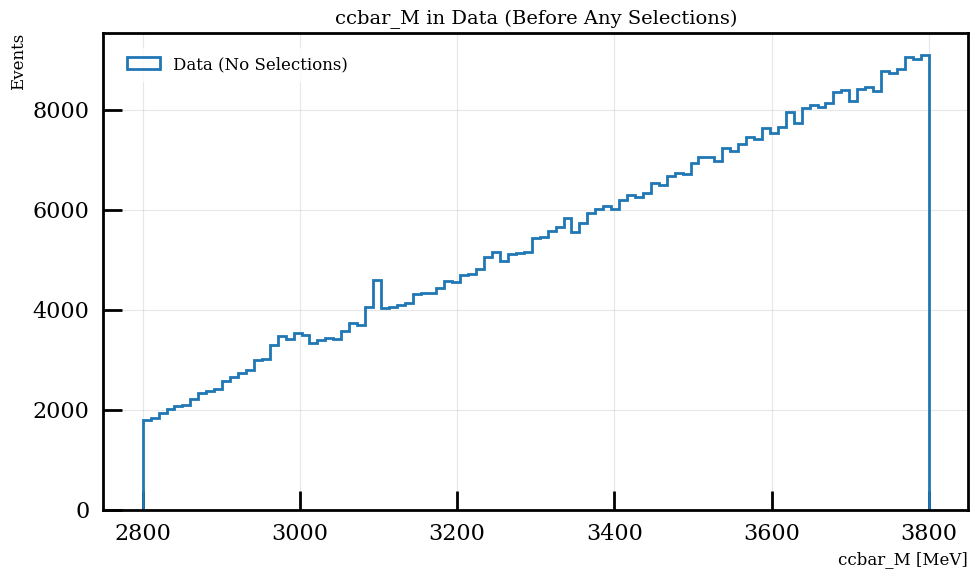

Total events: 1854771
ccbar_M statistics:
  Min: 2534.12626595438
  Max: 6502.230154508577
  Mean: 4270.9496343062165


In [9]:
# First, check if the 'data' dictionary has the necessary momentum components
print("Fields available in data:", list(data.fields))

# Make sure the ccbar_M calculation is applied to the combined data
# Calculate ccbar_M (invariant mass of L0-p-K combination) directly
data = ak.with_field(
    data,
    np.sqrt(
        (data["L0_PE"] + data["p_PE"] + data["h2_PE"])**2 -
        (data["L0_PX"] + data["p_PX"] + data["h2_PX"])**2 -
        (data["L0_PY"] + data["p_PY"] + data["h2_PY"])**2 -
        (data["L0_PZ"] + data["p_PZ"] + data["h2_PZ"])**2
    ),
    "ccbar_M"
)

# Check if ccbar_M was added successfully
print("Fields after calculation:", list(data.fields))
print("First few ccbar_M values:", data["ccbar_M"][:5])

# Now plot the histogram with NO selections
fig, ax = plt.subplots(figsize=(10, 6))

# Set the number of bins
bins = np.linspace(2800, 3800, 100)

# Plot the histogram - use all data without any selections
ax.hist(data["ccbar_M"], bins=bins, histtype="step", label="Data (No Selections)", linewidth=2)

# Add labels and title
ax.set_xlabel("ccbar_M [MeV]", fontsize=12)
ax.set_ylabel("Events", fontsize=12)
ax.set_title("ccbar_M in Data (Before Any Selections)", fontsize=14)

# Add a legend
ax.legend(fontsize=12)

# Show the plot
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Optional: Save the plot
# plt.savefig("ccbar_M_raw_histogram.png", dpi=300, bbox_inches="tight")

# Print some basic statistics about the distribution
print("Total events:", len(data))
print("ccbar_M statistics:")
print("  Min:", ak.min(data["ccbar_M"]))
print("  Max:", ak.max(data["ccbar_M"]))
print("  Mean:", ak.mean(data["ccbar_M"]))

Fields available in data: ['h1_P', 'h1_PT', 'h1_PE', 'h1_PX', 'h1_PY', 'h1_PZ', 'h1_ID', 'h1_TRACK_Type', 'h1_IPCHI2_OWNPV', 'h2_P', 'h2_PT', 'h2_PE', 'h2_PX', 'h2_PY', 'h2_PZ', 'h2_ID', 'h2_TRACK_Type', 'h2_IPCHI2_OWNPV', 'p_P', 'p_PT', 'p_PE', 'p_PX', 'p_PY', 'p_PZ', 'p_ID', 'p_TRACK_Type', 'p_IPCHI2_OWNPV', 'h1_MC15TuneV1_ProbNNk', 'h1_MC15TuneV1_ProbNNpi', 'h1_MC15TuneV1_ProbNNp', 'h1_MC15TuneV1_ProbNNmu', 'h2_MC15TuneV1_ProbNNk', 'h2_MC15TuneV1_ProbNNpi', 'h2_MC15TuneV1_ProbNNp', 'h2_MC15TuneV1_ProbNNmu', 'p_MC15TuneV1_ProbNNk', 'p_MC15TuneV1_ProbNNpi', 'p_MC15TuneV1_ProbNNp', 'p_MC15TuneV1_ProbNNmu', 'h1_ProbNNk', 'h1_ProbNNpi', 'h1_ProbNNp', 'h1_ProbNNmu', 'h2_ProbNNk', 'h2_ProbNNpi', 'h2_ProbNNp', 'h2_ProbNNmu', 'p_ProbNNk', 'p_ProbNNpi', 'p_ProbNNp', 'p_ProbNNmu', 'Lp_P', 'Lp_PT', 'Lp_PE', 'Lp_PX', 'Lp_PY', 'Lp_PZ', 'Lp_ID', 'Lp_TRACK_Type', 'Lpi_P', 'Lpi_PT', 'Lpi_PE', 'Lpi_PX', 'Lpi_PY', 'Lpi_PZ', 'Lpi_ID', 'Lpi_TRACK_Type', 'L0_P', 'L0_PT', 'L0_PE', 'L0_PX', 'L0_PY', 'L0_PZ

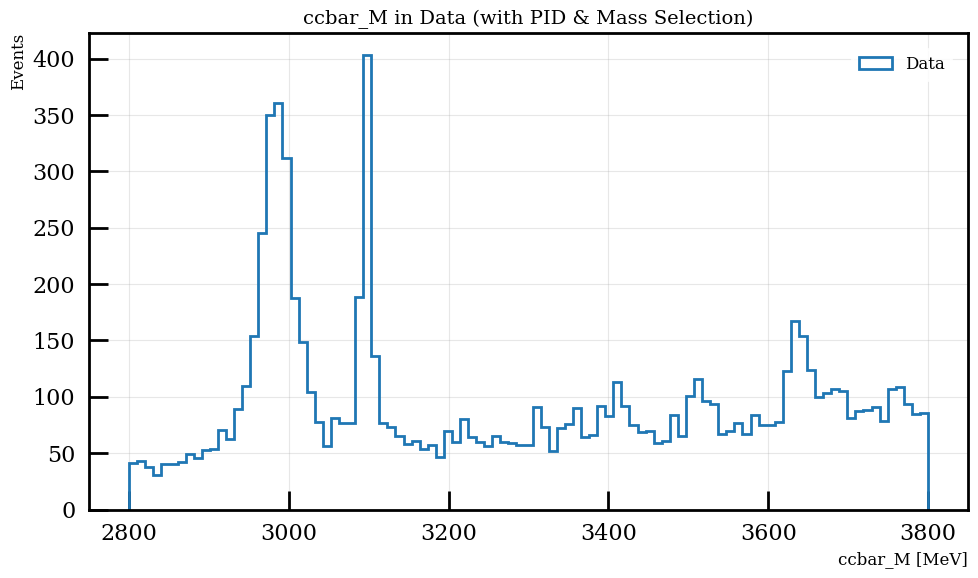

In [10]:
# First, check if the 'data' dictionary has the necessary momentum components
print("Fields available in data:", list(data.fields))

# Make sure the ccbar_M calculation is applied to the combined data
# Calculate ccbar_M (invariant mass of L0-p-K combination) directly
data = ak.with_field(
    data,
    np.sqrt(
        (data["L0_PE"] + data["p_PE"] + data["h2_PE"])**2 -
        (data["L0_PX"] + data["p_PX"] + data["h2_PX"])**2 -
        (data["L0_PY"] + data["p_PY"] + data["h2_PY"])**2 -
        (data["L0_PZ"] + data["p_PZ"] + data["h2_PZ"])**2
    ),
    "ccbar_M"
)

# Check if ccbar_M was added successfully
print("Fields after calculation:", list(data.fields))
print("First few ccbar_M values:", data["ccbar_M"][:5])

# First create the PID selection
pid_selection = (data["p_MC15TuneV1_ProbNNp"] * 
                 data["h1_MC15TuneV1_ProbNNk"] * 
                 data["h2_MC15TuneV1_ProbNNk"]) > 0.2

# Then apply this selection to the data array itself
data_selected = data[pid_selection]

# Now apply the mass cut on the already filtered data
# Check if Bu_DTFL0_M exists in the data
print("Checking for Bu_DTFL0_M field:", "Bu_DTFL0_M" in data_selected.fields)

# Print all available fields to see what we can use for mass selection
print("All available fields after PID selection:", list(data_selected.fields))

# If Bu_DTFL0_M exists, apply the mass cut
if "Bu_DTFL0_M" in data_selected.fields:
    mass_selection = np.abs(data_selected["Bu_DTFL0_M"] - 5279.6) < 30
    data_final = data_selected[mass_selection]
else:
    # If the field doesn't exist, we'll just use the PID selection for now
    print("Warning: Bu_DTFL0_M field not found. Skipping mass selection.")
    data_final = data_selected
    
    # Check if "Bu_M" exists as an alternative
    if "Bu_M" in data_selected.fields:
        print("Found Bu_M instead. Using this for mass selection.")
        mass_selection = np.abs(data_selected["Bu_M"] - 5279.6) < 30
        data_final = data_selected[mass_selection]

# Now plot the histogram
fig, ax = plt.subplots(figsize=(10, 6))

# Set the number of bins
bins = np.linspace(2800, 3800, 100)

# Plot the histogram - use the correctly selected data
ax.hist(data_final["ccbar_M"], bins=bins, histtype="step", label="Data", linewidth=2)

# Add labels and title
ax.set_xlabel("ccbar_M [MeV]", fontsize=12)
ax.set_ylabel("Events", fontsize=12)
ax.set_title("ccbar_M in Data (with PID & Mass Selection)", fontsize=14)

# Add a legend
ax.legend(fontsize=12)

# Show the plot
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Optional: Save the plot
# plt.savefig("ccbar_M_histogram.png", dpi=300, bbox_inches="tight")

## Pre-selections

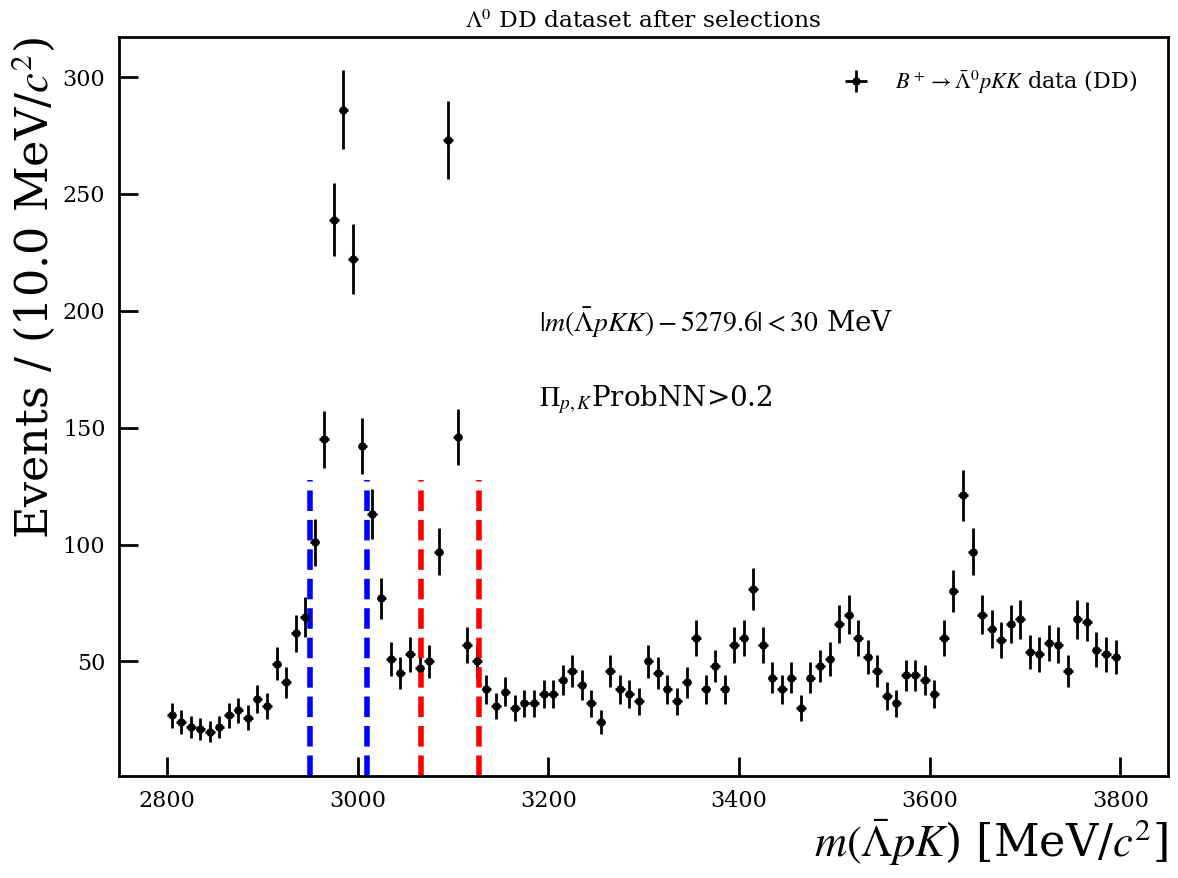

In [11]:
# Constants for the plot
mjpsi = 3096.9  # J/psi mass
decay = r"$B^+\to \bar{\Lambda}^0pKK$"

# Plot for DD dataset
if data_dd is not None:
    # DD selection
    selection_dd = (data_dd["p_MC15TuneV1_ProbNNp"] * data_dd["h1_MC15TuneV1_ProbNNk"] * data_dd["h2_MC15TuneV1_ProbNNk"]) > 0.2
    data_dd_selected = data_dd[selection_dd]
    
    fig, ax = plt.subplots()
    ranges, bins = [2800, 3800], 100
    width = round((ranges[1] - ranges[0]) / bins, 1)
    histstyle = {"range": ranges, "bins": bins, "density": False}
    
    # Plot data with B mass window selection
    mass_selection = np.abs(data_dd_selected["Bu_DTFL0_M"] - 5279.6) < 30
    plot_data(ax, data_dd_selected["ccbar_M"][mass_selection].tolist(), decay + " data (DD)", histstyle)
    
    # Add vertical lines for reference
    ax.axvline(x=mjpsi-30, ymax=0.4, color="red", ls="--")
    ax.axvline(x=mjpsi+30, ymax=0.4, color="red", ls="--")
    ax.axvline(x=2980.3-30, ymax=0.4, color="blue", ls="--")
    ax.axvline(x=2980.3+30, ymax=0.4, color="blue", ls="--")
    
    # Set plot labels and annotations
    ax.set_title(r"$\Lambda^0$ DD dataset after selections")
    ax.set_xlabel(r"$m(\bar{\Lambda}pK$) [MeV/$c^2$]")
    ax.set_ylabel(f"Events / ({width} MeV/$c^2$)")
    plt.text(0.4, 0.6, r"$|m(\bar{\Lambda}pKK)-5279.6|<30$ MeV", transform=ax.transAxes, fontsize=20)
    plt.text(0.4, 0.5, r"$\Pi_{p,K}$ProbNN>0.2", transform=ax.transAxes, fontsize=20)
    ax.legend()
    plt.savefig("ccbar_mass_DD.pdf", dpi=300, bbox_inches='tight')
    plt.show()



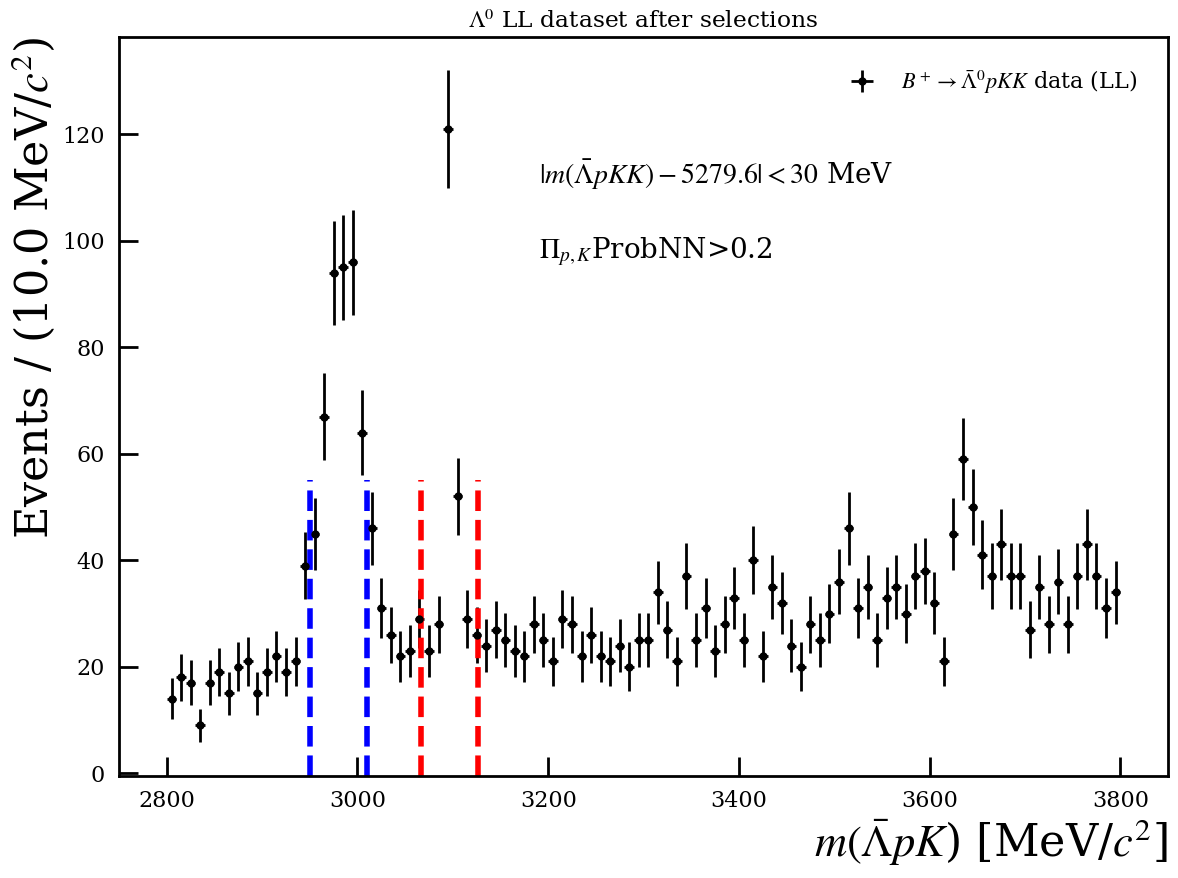

In [12]:
# Plot for LL dataset
if data_ll is not None:
    # LL selection
    selection_ll = (data_ll["p_MC15TuneV1_ProbNNp"] * data_ll["h1_MC15TuneV1_ProbNNk"] * data_ll["h2_MC15TuneV1_ProbNNk"]) > 0.2
    data_ll_selected = data_ll[selection_ll]
    
    fig, ax = plt.subplots()
    ranges, bins = [2800, 3800], 100
    width = round((ranges[1] - ranges[0]) / bins, 1)
    histstyle = {"range": ranges, "bins": bins, "density": False}
    
    # Plot data with B mass window selection
    mass_selection = np.abs(data_ll_selected["Bu_DTFL0_M"] - 5279.6) < 30
    plot_data(ax, data_ll_selected["ccbar_M"][mass_selection].tolist(), decay + " data (LL)", histstyle)
    # Add vertical lines for reference
    ax.axvline(x=mjpsi-30, ymax=0.4, color="red", ls="--")
    ax.axvline(x=mjpsi+30, ymax=0.4, color="red", ls="--")
    ax.axvline(x=2980.3-30, ymax=0.4, color="blue", ls="--")
    ax.axvline(x=2980.3+30, ymax=0.4, color="blue", ls="--")
    
    # Set plot labels and annotations
    ax.set_title(r"$\Lambda^0$ LL dataset after selections")
    ax.set_xlabel(r"$m(\bar{\Lambda}pK$) [MeV/$c^2$]")
    ax.set_ylabel(f"Events / ({width} MeV/$c^2$)")
    plt.text(0.4, 0.8, r"$|m(\bar{\Lambda}pKK)-5279.6|<30$ MeV", transform=ax.transAxes, fontsize=20)
    plt.text(0.4, 0.7, r"$\Pi_{p,K}$ProbNN>0.2", transform=ax.transAxes, fontsize=20)
    ax.legend()
    plt.savefig("ccbar_mass_LL.pdf", dpi=300, bbox_inches='tight')
    plt.show()



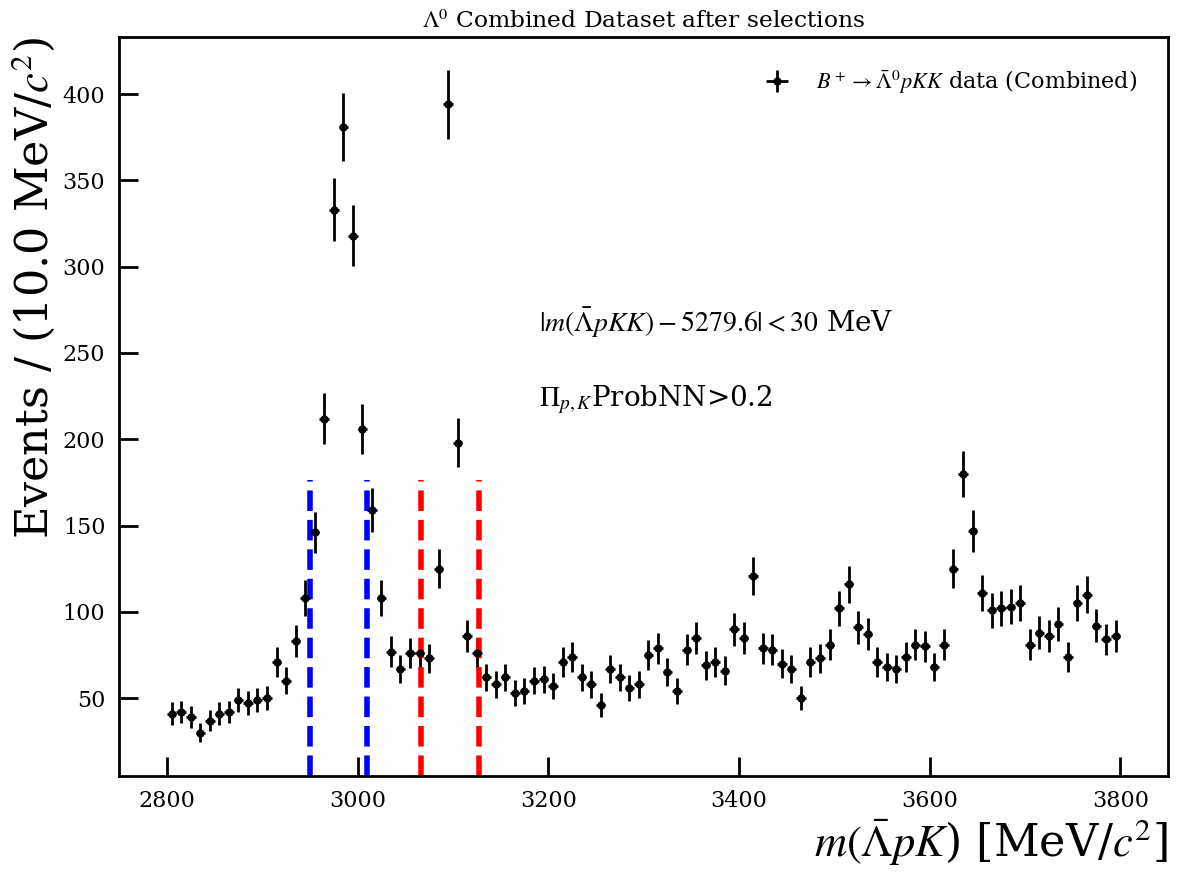

In [13]:
# Plot for combined dataset (if available)
if 'data' in locals() and data is not None:
    # For the combined dataset, we'll apply the respective selections based on track type
    # This assumes we have track_type information in the combined dataset
    if 'track_type' in data.fields:
        # Apply different selections based on track type
        dd_mask = data['track_type'] == 'DD'
        ll_mask = data['track_type'] == 'LL'
        
        probnn_selection = (
            (dd_mask & ((data["p_MC15TuneV1_ProbNNp"] * data["h1_MC15TuneV1_ProbNNk"] * data["h2_MC15TuneV1_ProbNNk"]) > 0.2)) |
            (ll_mask & ((data["p_MC15TuneV1_ProbNNp"] * data["h1_MC15TuneV1_ProbNNk"] * data["h2_MC15TuneV1_ProbNNk"]) > 0.2))
        )
    else:
        # If no track_type info, use a general selection
        probnn_selection = (data["p_MC15TuneV1_ProbNNp"] * data["h1_MC15TuneV1_ProbNNk"] * data["h2_MC15TuneV1_ProbNNk"]) > 0.2
    
    data_selected = data[probnn_selection]
    
    fig, ax = plt.subplots()
    ranges, bins = [2800, 3800], 100
    width = round((ranges[1] - ranges[0]) / bins, 1)
    histstyle = {"range": ranges, "bins": bins, "density": False}
    
    # Plot data with B mass window selection
    mass_selection = np.abs(data_selected["Bu_DTFL0_M"] - 5279.6) < 30
    plot_data(ax, data_selected["ccbar_M"][mass_selection].tolist(), decay + " data (Combined)", histstyle)
    
    # Add vertical lines for reference
    ax.axvline(x=mjpsi-30, ymax=0.4, color="red", ls="--")
    ax.axvline(x=mjpsi+30, ymax=0.4, color="red", ls="--")
    ax.axvline(x=2980.3-30, ymax=0.4, color="blue", ls="--")
    ax.axvline(x=2980.3+30, ymax=0.4, color="blue", ls="--")
    
    # Set plot labels and annotations
    ax.set_title(r"$\Lambda^0$ Combined Dataset after selections")
    ax.set_xlabel(r"$m(\bar{\Lambda}pK$) [MeV/$c^2$]")
    ax.set_ylabel(f"Events / ({width} MeV/$c^2$)")
    plt.text(0.4, 0.6, r"$|m(\bar{\Lambda}pKK)-5279.6|<30$ MeV", transform=ax.transAxes, fontsize=20)
    plt.text(0.4, 0.5, r"$\Pi_{p,K}$ProbNN>0.2", transform=ax.transAxes, fontsize=20)
    ax.legend()
    plt.savefig("ccbar_mass_combined.pdf", dpi=300, bbox_inches='tight')
    plt.show()



Checking for B_MM field in data_dd: False
Checking for B_MM field in data_ll: False
All fields in data_dd: ['h1_P', 'h1_PT', 'h1_PE', 'h1_PX', 'h1_PY', 'h1_PZ', 'h1_ID', 'h1_TRACK_Type', 'h1_IPCHI2_OWNPV', 'h2_P', 'h2_PT', 'h2_PE', 'h2_PX', 'h2_PY', 'h2_PZ', 'h2_ID', 'h2_TRACK_Type', 'h2_IPCHI2_OWNPV', 'p_P', 'p_PT', 'p_PE', 'p_PX', 'p_PY', 'p_PZ', 'p_ID', 'p_TRACK_Type', 'p_IPCHI2_OWNPV', 'h1_MC15TuneV1_ProbNNk', 'h1_MC15TuneV1_ProbNNpi', 'h1_MC15TuneV1_ProbNNp', 'h1_MC15TuneV1_ProbNNmu', 'h2_MC15TuneV1_ProbNNk', 'h2_MC15TuneV1_ProbNNpi', 'h2_MC15TuneV1_ProbNNp', 'h2_MC15TuneV1_ProbNNmu', 'p_MC15TuneV1_ProbNNk', 'p_MC15TuneV1_ProbNNpi', 'p_MC15TuneV1_ProbNNp', 'p_MC15TuneV1_ProbNNmu', 'h1_ProbNNk', 'h1_ProbNNpi', 'h1_ProbNNp', 'h1_ProbNNmu', 'h2_ProbNNk', 'h2_ProbNNpi', 'h2_ProbNNp', 'h2_ProbNNmu', 'p_ProbNNk', 'p_ProbNNpi', 'p_ProbNNp', 'p_ProbNNmu', 'Lp_P', 'Lp_PT', 'Lp_PE', 'Lp_PX', 'Lp_PY', 'Lp_PZ', 'Lp_ID', 'Lp_TRACK_Type', 'Lpi_P', 'Lpi_PT', 'Lpi_PE', 'Lpi_PX', 'Lpi_PY', 'Lpi_PZ

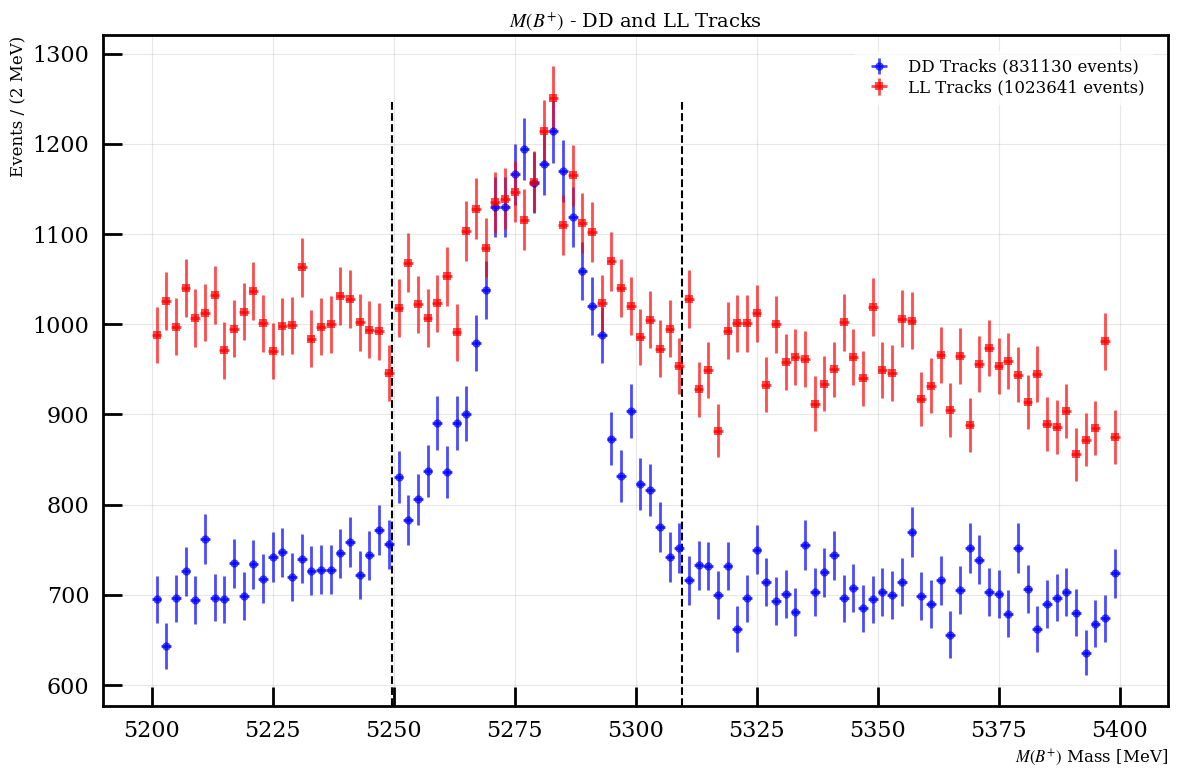

In [14]:
# Check if B_MM field exists in the data
print("Checking for B_MM field in data_dd:", "B_MM" in data_dd.fields)
print("Checking for B_MM field in data_ll:", "B_MM" in data_ll.fields)

# Print all available fields to find the right B mass variable
print("All fields in data_dd:", list(data_dd.fields))

# Find the right B mass variable - common names include B_M, Bu_M, B_MM, etc.
possible_b_mass_fields = ["B_MM", "B_M", "Bu_M", "Bu_MM", "B_DTFL0_M", "Bu_DTFL0_M"]

# Find which field exists in the data
dd_mass_field = None
ll_mass_field = None

for field in possible_b_mass_fields:
    if field in data_dd.fields:
        dd_mass_field = field
        print(f"Found B mass field in DD data: {field}")
        break

for field in possible_b_mass_fields:
    if field in data_ll.fields:
        ll_mass_field = field
        print(f"Found B mass field in LL data: {field}")
        break

if not dd_mass_field or not ll_mass_field:
    print("Warning: Could not find B mass field in one or both datasets")
    # Try to use the calculated missing mass if available
    if "B_MM" not in data_dd.fields and "B_MM" not in data_ll.fields:
        print("Calculating missing mass (B_MM) for both datasets")
        
        # Calculate B_MM for DD tracks if needed
        if "Bu_P" in data_dd.fields and "Bu_PT" in data_dd.fields:
            data_dd = ak.with_field(
                data_dd,
                np.sqrt(data_dd["Bu_P"]**2 + data_dd["Bu_PT"]**2),
                "B_MM"
            )
            dd_mass_field = "B_MM"
            
        # Calculate B_MM for LL tracks if needed
        if "Bu_P" in data_ll.fields and "Bu_PT" in data_ll.fields:
            data_ll = ak.with_field(
                data_ll,
                np.sqrt(data_ll["Bu_P"]**2 + data_ll["Bu_PT"]**2),
                "B_MM"
            )
            ll_mass_field = "B_MM"

# Now create the figure for plotting
fig, ax = plt.subplots(figsize=(12, 8))

# Define mass range and bins
mass_min = 5200  # MeV
mass_max = 5400  # MeV
bins = 100  # Number of bins

# Define histogram style parameters
histstyle_dd = {
    'bins': bins,
    'range': (mass_min, mass_max),
    'density': False,
    'linewidth': 2,
    'alpha': 0.7
}

histstyle_ll = {
    'bins': bins,
    'range': (mass_min, mass_max),
    'density': False,
    'linewidth': 2,
    'alpha': 0.7
}

# Initialize variables to track histogram data
dd_hist = None
ll_hist = None
dd_data = None
ll_data = None

# Plot DD tracks if field exists
if dd_mass_field:
    dd_data = ak.to_numpy(data_dd[dd_mass_field])
    ax, dd_hist, dd_errors = plot_data(
        ax=ax,
        data=dd_data,
        label=f"DD Tracks ({len(data_dd)} events)",
        histstyle=histstyle_dd,
        color="blue",
        errorbar=True,
        mkstyle='o'
    )

# Plot LL tracks if field exists
if ll_mass_field:
    ll_data = ak.to_numpy(data_ll[ll_mass_field])
    ax, ll_hist, ll_errors = plot_data(
        ax=ax,
        data=ll_data,
        label=f"LL Tracks ({len(data_ll)} events)",
        histstyle=histstyle_ll,
        color="red",
        errorbar=True,
        mkstyle='s'  # Square markers to differentiate from DD
    )

# Add labels and title
ax.set_xlabel(r"$M(B^{+})$ Mass [MeV]", fontsize=12)
ax.set_ylabel(r"Events / (2 MeV)", fontsize=12)
ax.set_title(r"$M(B^{+})$ - DD and LL Tracks", fontsize=14)

# Add a legend
ax.legend(fontsize=12)

# Show grid
plt.grid(True, alpha=0.3)

# Define B+ mass region boundaries (PDG value ± 30 MeV)
b_plus_mass = 5279.6  # MeV/c²
mass_window = 30  # MeV
lower_bound = b_plus_mass - mass_window
upper_bound = b_plus_mass + mass_window

# Find the maximum height in the histograms within the mass window region
max_height = 0
if dd_hist is not None:
    # Get bin edges
    bin_edges = np.linspace(mass_min, mass_max, bins + 1)
    # Find the bins that fall within the mass window
    window_bins = np.where((bin_edges >= lower_bound) & (bin_edges <= upper_bound))[0]
    if len(window_bins) > 0:
        # Get the maximum height in the window region
        window_max_dd = np.max(dd_hist[window_bins[0]-1:window_bins[-1]])
        max_height = max(max_height, window_max_dd)

if ll_hist is not None:
    # Get bin edges
    bin_edges = np.linspace(mass_min, mass_max, bins + 1)
    # Find the bins that fall within the mass window
    window_bins = np.where((bin_edges >= lower_bound) & (bin_edges <= upper_bound))[0]
    if len(window_bins) > 0:
        # Get the maximum height in the window region
        window_max_ll = np.max(ll_hist[window_bins[0]-1:window_bins[-1]])
        max_height = max(max_height, window_max_ll)

# Add dashed vertical lines at the boundary of the B+ mass region
ax.axvline(x=lower_bound, ymin=0, ymax=0.9, color='black', linestyle='--', 
           linewidth=1.5, label=f"B+ Mass Window (±{mass_window} MeV)")
ax.axvline(x=upper_bound, ymin=0, ymax=0.9, color='black', linestyle='--', 
           linewidth=1.5)

# Get the current y-axis limits
y_min, y_max = ax.get_ylim()



plt.tight_layout()
plt.show()

# Optional: Save the plot
# plt.savefig("B_mass_DD_LL_comparison_with_window.png", dpi=300, bbox_inches="tight")

Checking for B_MM field in data_dd: False
Checking for B_MM field in data_ll: False
Checking for L0_MM field in data_dd: True
Checking for L0_MM field in data_ll: True
All fields in data_dd: ['h1_P', 'h1_PT', 'h1_PE', 'h1_PX', 'h1_PY', 'h1_PZ', 'h1_ID', 'h1_TRACK_Type', 'h1_IPCHI2_OWNPV', 'h2_P', 'h2_PT', 'h2_PE', 'h2_PX', 'h2_PY', 'h2_PZ', 'h2_ID', 'h2_TRACK_Type', 'h2_IPCHI2_OWNPV', 'p_P', 'p_PT', 'p_PE', 'p_PX', 'p_PY', 'p_PZ', 'p_ID', 'p_TRACK_Type', 'p_IPCHI2_OWNPV', 'h1_MC15TuneV1_ProbNNk', 'h1_MC15TuneV1_ProbNNpi', 'h1_MC15TuneV1_ProbNNp', 'h1_MC15TuneV1_ProbNNmu', 'h2_MC15TuneV1_ProbNNk', 'h2_MC15TuneV1_ProbNNpi', 'h2_MC15TuneV1_ProbNNp', 'h2_MC15TuneV1_ProbNNmu', 'p_MC15TuneV1_ProbNNk', 'p_MC15TuneV1_ProbNNpi', 'p_MC15TuneV1_ProbNNp', 'p_MC15TuneV1_ProbNNmu', 'h1_ProbNNk', 'h1_ProbNNpi', 'h1_ProbNNp', 'h1_ProbNNmu', 'h2_ProbNNk', 'h2_ProbNNpi', 'h2_ProbNNp', 'h2_ProbNNmu', 'p_ProbNNk', 'p_ProbNNpi', 'p_ProbNNp', 'p_ProbNNmu', 'Lp_P', 'Lp_PT', 'Lp_PE', 'Lp_PX', 'Lp_PY', 'Lp_PZ'

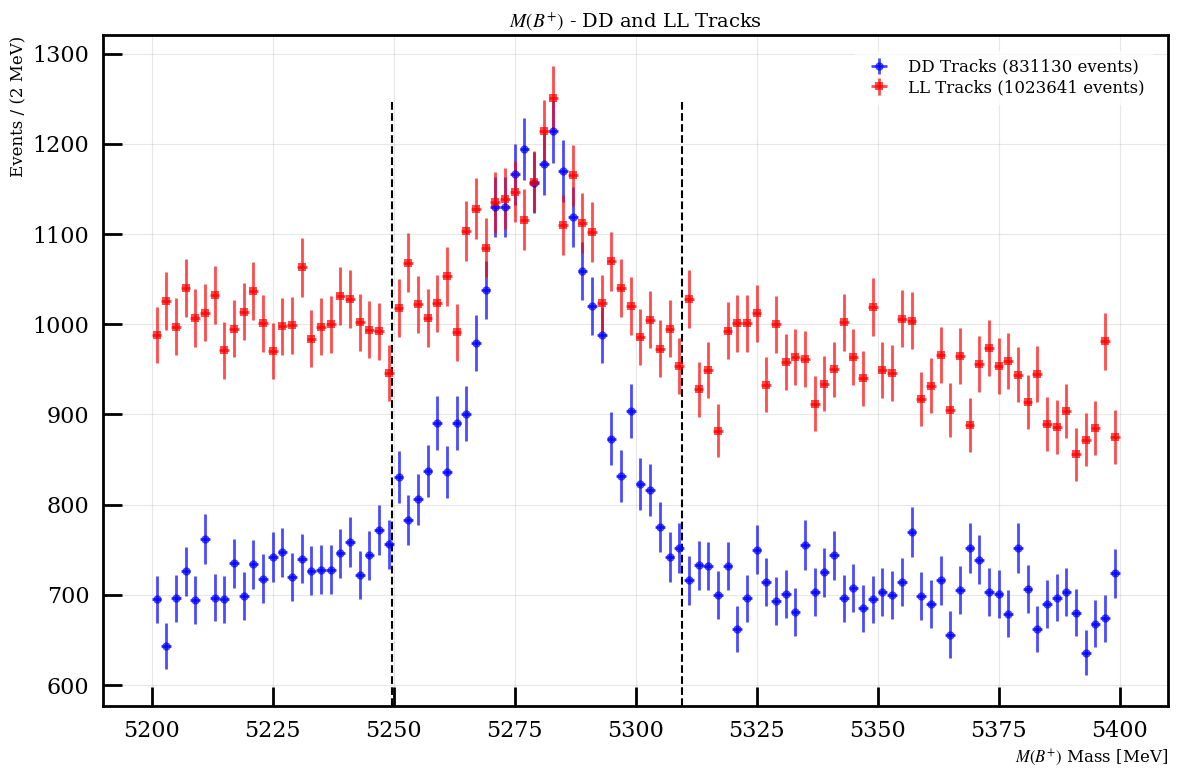

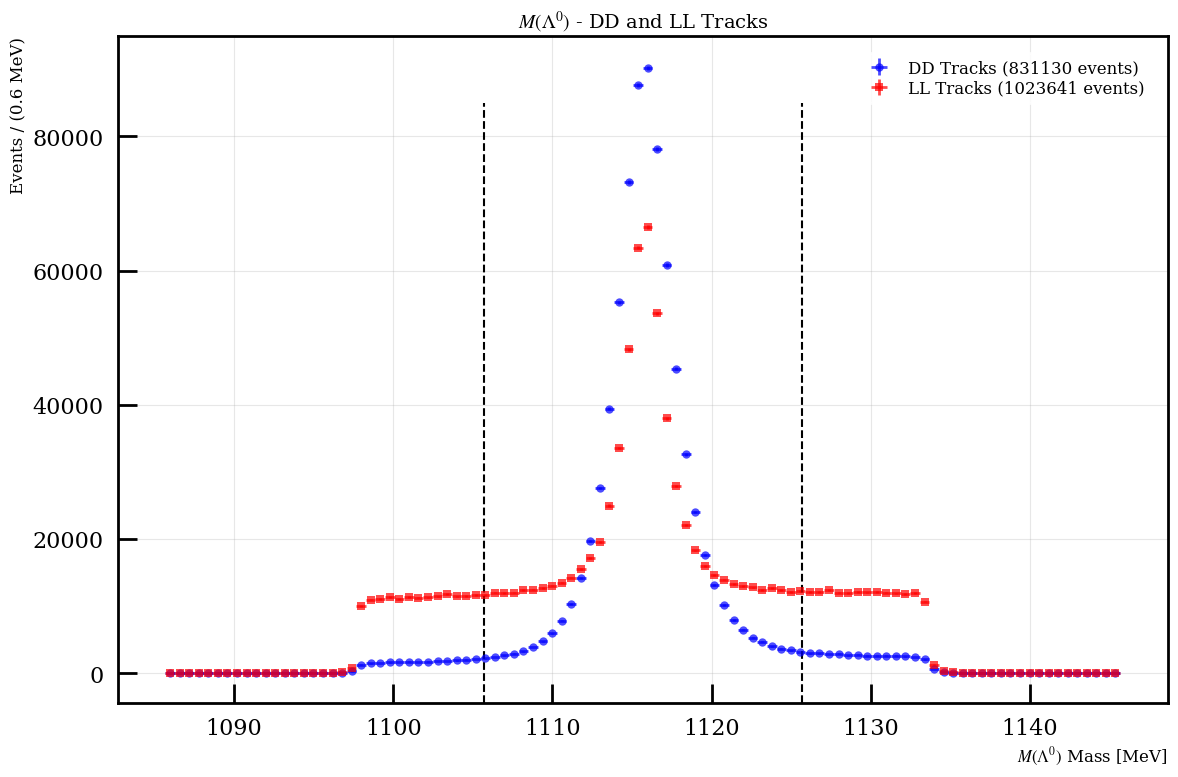

In [15]:
# Check if B_MM field exists in the data
print("Checking for B_MM field in data_dd:", "B_MM" in data_dd.fields)
print("Checking for B_MM field in data_ll:", "B_MM" in data_ll.fields)

# Check if L0_MM (Lambda mass) field exists in the data
print("Checking for L0_MM field in data_dd:", "L0_MM" in data_dd.fields)
print("Checking for L0_MM field in data_ll:", "L0_MM" in data_ll.fields)

# Print all available fields to find the right B mass and Lambda mass variables
print("All fields in data_dd:", list(data_dd.fields))
print("All fields in data_ll:", list(data_ll.fields))

# Find the right B mass variable - common names include B_M, Bu_M, B_MM, etc.
possible_b_mass_fields = ["B_MM", "B_M", "Bu_M", "Bu_MM", "B_DTFL0_M", "Bu_DTFL0_M"]
possible_lambda_mass_fields = ["L0_MM", "L0_M", "Lambda_MM", "Lambda_M"]

# Find which field exists in the data
dd_mass_field = None
ll_mass_field = None
dd_lambda_mass_field = None
ll_lambda_mass_field = None

for field in possible_b_mass_fields:
    if field in data_dd.fields:
        dd_mass_field = field
        print(f"Found B mass field in DD data: {field}")
        break

for field in possible_b_mass_fields:
    if field in data_ll.fields:
        ll_mass_field = field
        print(f"Found B mass field in LL data: {field}")
        break

# Find Lambda mass fields
for field in possible_lambda_mass_fields:
    if field in data_dd.fields:
        dd_lambda_mass_field = field
        print(f"Found Lambda mass field in DD data: {field}")
        break

for field in possible_lambda_mass_fields:
    if field in data_ll.fields:
        ll_lambda_mass_field = field
        print(f"Found Lambda mass field in LL data: {field}")
        break

if not dd_mass_field or not ll_mass_field:
    print("Warning: Could not find B mass field in one or both datasets")
    # Try to use the calculated missing mass if available
    if "B_MM" not in data_dd.fields and "B_MM" not in data_ll.fields:
        print("Calculating missing mass (B_MM) for both datasets")
        
        # Calculate B_MM for DD tracks if needed
        if "Bu_P" in data_dd.fields and "Bu_PT" in data_dd.fields:
            data_dd = ak.with_field(
                data_dd,
                np.sqrt(data_dd["Bu_P"]**2 + data_dd["Bu_PT"]**2),
                "B_MM"
            )
            dd_mass_field = "B_MM"
            
        # Calculate B_MM for LL tracks if needed
        if "Bu_P" in data_ll.fields and "Bu_PT" in data_ll.fields:
            data_ll = ak.with_field(
                data_ll,
                np.sqrt(data_ll["Bu_P"]**2 + data_ll["Bu_PT"]**2),
                "B_MM"
            )
            ll_mass_field = "B_MM"

# Print Lambda mass statistics if available
if dd_lambda_mass_field:
    lambda_mass_dd = ak.to_numpy(data_dd[dd_lambda_mass_field])
    print("\nLambda Mass (DD tracks) statistics:")
    print(f"Mean: {np.mean(lambda_mass_dd):.2f} MeV")
    print(f"Median: {np.median(lambda_mass_dd):.2f} MeV")
    print(f"Min: {np.min(lambda_mass_dd):.2f} MeV")
    print(f"Max: {np.max(lambda_mass_dd):.2f} MeV")
    print(f"Standard deviation: {np.std(lambda_mass_dd):.2f} MeV")
    print(f"Number of events: {len(lambda_mass_dd)}")
else:
    print("\nWarning: Lambda mass field not found in DD data")

if ll_lambda_mass_field:
    lambda_mass_ll = ak.to_numpy(data_ll[ll_lambda_mass_field])
    print("\nLambda Mass (LL tracks) statistics:")
    print(f"Mean: {np.mean(lambda_mass_ll):.2f} MeV")
    print(f"Median: {np.median(lambda_mass_ll):.2f} MeV")
    print(f"Min: {np.min(lambda_mass_ll):.2f} MeV")
    print(f"Max: {np.max(lambda_mass_ll):.2f} MeV")
    print(f"Standard deviation: {np.std(lambda_mass_ll):.2f} MeV")
    print(f"Number of events: {len(lambda_mass_ll)}")
else:
    print("\nWarning: Lambda mass field not found in LL data")

# Now create the figure for plotting B mass
fig, ax = plt.subplots(figsize=(12, 8))

# Define mass range and bins
mass_min = 5200  # MeV
mass_max = 5400  # MeV
bins = 100  # Number of bins

# Define histogram style parameters
histstyle_dd = {
    'bins': bins,
    'range': (mass_min, mass_max),
    'density': False,
    'linewidth': 2,
    'alpha': 0.7
}

histstyle_ll = {
    'bins': bins,
    'range': (mass_min, mass_max),
    'density': False,
    'linewidth': 2,
    'alpha': 0.7
}

# Initialize variables to track histogram data
dd_hist = None
ll_hist = None
dd_data = None
ll_data = None

# Plot DD tracks if field exists
if dd_mass_field:
    dd_data = ak.to_numpy(data_dd[dd_mass_field])
    ax, dd_hist, dd_errors = plot_data(
        ax=ax,
        data=dd_data,
        label=f"DD Tracks ({len(data_dd)} events)",
        histstyle=histstyle_dd,
        color="blue",
        errorbar=True,
        mkstyle='o'
    )

# Plot LL tracks if field exists
if ll_mass_field:
    ll_data = ak.to_numpy(data_ll[ll_mass_field])
    ax, ll_hist, ll_errors = plot_data(
        ax=ax,
        data=ll_data,
        label=f"LL Tracks ({len(data_ll)} events)",
        histstyle=histstyle_ll,
        color="red",
        errorbar=True,
        mkstyle='s'  # Square markers to differentiate from DD
    )

# Add labels and title
ax.set_xlabel(r"$M(B^{+})$ Mass [MeV]", fontsize=12)
ax.set_ylabel(r"Events / (2 MeV)", fontsize=12)
ax.set_title(r"$M(B^{+})$ - DD and LL Tracks", fontsize=14)

# Add a legend
ax.legend(fontsize=12)

# Show grid
plt.grid(True, alpha=0.3)

# Define B+ mass region boundaries (PDG value ± 30 MeV)
b_plus_mass = 5279.6  # MeV/c²
mass_window = 30  # MeV
lower_bound = b_plus_mass - mass_window
upper_bound = b_plus_mass + mass_window

# Find the maximum height in the histograms within the mass window region
max_height = 0
if dd_hist is not None:
    # Get bin edges
    bin_edges = np.linspace(mass_min, mass_max, bins + 1)
    # Find the bins that fall within the mass window
    window_bins = np.where((bin_edges >= lower_bound) & (bin_edges <= upper_bound))[0]
    if len(window_bins) > 0:
        # Get the maximum height in the window region
        window_max_dd = np.max(dd_hist[window_bins[0]-1:window_bins[-1]])
        max_height = max(max_height, window_max_dd)

if ll_hist is not None:
    # Get bin edges
    bin_edges = np.linspace(mass_min, mass_max, bins + 1)
    # Find the bins that fall within the mass window
    window_bins = np.where((bin_edges >= lower_bound) & (bin_edges <= upper_bound))[0]
    if len(window_bins) > 0:
        # Get the maximum height in the window region
        window_max_ll = np.max(ll_hist[window_bins[0]-1:window_bins[-1]])
        max_height = max(max_height, window_max_ll)

# Add dashed vertical lines at the boundary of the B+ mass region
ax.axvline(x=lower_bound, ymin=0, ymax=0.9, color='black', linestyle='--', 
           linewidth=1.5, label=f"B+ Mass Window (±{mass_window} MeV)")
ax.axvline(x=upper_bound, ymin=0, ymax=0.9, color='black', linestyle='--', 
           linewidth=1.5)

# Get the current y-axis limits
y_min, y_max = ax.get_ylim()

plt.tight_layout()
plt.show()

# Create a new figure for plotting Lambda mass if available
if dd_lambda_mass_field or ll_lambda_mass_field:
    fig_lambda, ax_lambda = plt.subplots(figsize=(12, 8))
    
    # Define Lambda mass range and bins
    lambda_mass_pdg = 1115.683  # MeV/c²
    lambda_mass_min = lambda_mass_pdg - 30  # MeV
    lambda_mass_max = lambda_mass_pdg + 30  # MeV
    lambda_bins = 100  # Number of bins
    
    # Define histogram style parameters for Lambda
    lambda_histstyle_dd = {
        'bins': lambda_bins,
        'range': (lambda_mass_min, lambda_mass_max),
        'density': False,
        'linewidth': 2,
        'alpha': 0.7
    }
    
    lambda_histstyle_ll = {
        'bins': lambda_bins,
        'range': (lambda_mass_min, lambda_mass_max),
        'density': False,
        'linewidth': 2,
        'alpha': 0.7
    }
    
    # Plot DD Lambda tracks if field exists
    if dd_lambda_mass_field:
        lambda_dd_data = ak.to_numpy(data_dd[dd_lambda_mass_field])
        ax_lambda, lambda_dd_hist, lambda_dd_errors = plot_data(
            ax=ax_lambda,
            data=lambda_dd_data,
            label=f"DD Tracks ({len(data_dd)} events)",
            histstyle=lambda_histstyle_dd,
            color="blue",
            errorbar=True,
            mkstyle='o'
        )
    
    # Plot LL Lambda tracks if field exists
    if ll_lambda_mass_field:
        lambda_ll_data = ak.to_numpy(data_ll[ll_lambda_mass_field])
        ax_lambda, lambda_ll_hist, lambda_ll_errors = plot_data(
            ax=ax_lambda,
            data=lambda_ll_data,
            label=f"LL Tracks ({len(data_ll)} events)",
            histstyle=lambda_histstyle_ll,
            color="red",
            errorbar=True,
            mkstyle='s'  # Square markers to differentiate from DD
        )
    
    # Add labels and title for Lambda plot
    ax_lambda.set_xlabel(r"$M(\Lambda^{0})$ Mass [MeV]", fontsize=12)
    ax_lambda.set_ylabel(r"Events / (0.6 MeV)", fontsize=12)
    ax_lambda.set_title(r"$M(\Lambda^{0})$ - DD and LL Tracks", fontsize=14)
    
    # Add a legend for Lambda plot
    ax_lambda.legend(fontsize=12)
    
    # Show grid for Lambda plot
    plt.grid(True, alpha=0.3)
    
    # Define Lambda mass region boundaries (PDG value ± 10 MeV)
    lambda_window = 10  # MeV
    lambda_lower_bound = lambda_mass_pdg - lambda_window
    lambda_upper_bound = lambda_mass_pdg + lambda_window
    
    # Add dashed vertical lines at the boundary of the Lambda mass region
    ax_lambda.axvline(x=lambda_lower_bound, ymin=0, ymax=0.9, color='black', linestyle='--', 
               linewidth=1.5, label=f"Lambda Mass Window (±{lambda_window} MeV)")
    ax_lambda.axvline(x=lambda_upper_bound, ymin=0, ymax=0.9, color='black', linestyle='--', 
               linewidth=1.5)
    
    plt.tight_layout()
    plt.show()
    
    # Optional: Save the Lambda plot
    # plt.savefig("Lambda_mass_DD_LL_comparison_with_window.png", dpi=300, bbox_inches="tight")

# Optional: Save the B mass plot
# plt.savefig("B_mass_DD_LL_comparison_with_window.png", dpi=300, bbox_inches="tight")